In [14]:
import json
import pandas as pd

# --- Load interpretation files with weighted posteriors ---
with open("../src/interpretations_new.json", "r") as f:
    interpretations_default = json.load(f)
with open("../src/interpretations_new_with_weighted_posteriors.json", "r") as f:
    interpretations_new = json.load(f)
with open("../src/interpretations_llm_flat_with_weighted_posteriors.json", "r") as f:
    interpretations_llm = json.load(f)



with open("../src/interpretations_new_llm_approach_May7_flat_with_weighted.json", "r") as f:
    interpretations = json.load(f)

# with open("../src/interpretations.json", "r") as f:
#     interpretations_default = json.load(f)
# with open("../src/interpretations.json", "r") as f:
#     interpretations_new = json.load(f)
# with open("../src/interpretations.json", "r") as f:
#     interpretations_llm = json.load(f)

# --- Load evaluation and mapping data ---
evaluation_df = pd.read_csv("../data/alab_synthesis_data/Dara-AIF_evaluation.csv")
mapping_df = pd.read_csv("../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv")
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]
evaluation_df = evaluation_df.dropna(subset=["Prefered Interpretation"])

# --- Define sample-specific source selection ---
use_new_samples = [] #["TRI_130", "TRI_197"]
use_llm_samples = []#["TRI_182"]

# --- Helpers ---
def normalize_key(name):
    return name.strip().replace("-", "_")

def get_sample(tri_key):
    if tri_key in use_new_samples:
        return interpretations_new.get(tri_key, {})
    elif tri_key in use_llm_samples:
        return interpretations_llm.get(tri_key, {})
    else:
        return interpretations_default.get(tri_key, {})

# --- Weights for recomputing posterior ---

# w_llm = 0.5
# w_bs = 1
# w_rwp = 0.4
# w_score = 1
# agreement = 64.4
w_llm = 0.2
w_bs = 0.6
w_rwp = 1
w_score = 0.4
agreement = 68.89#??


# --- Compare selections ---
comparison_rows = []

for _, row in evaluation_df.iterrows():
    run_name = row["Run Name in ALAB"]
    tri_key = normalize_key(run_name)
    chemist_pref = row["Prefered Interpretation"]
    score_a = row["Interpretation A: Human Evaluation (0-1, 1 is best)"]
    score_b = row["Interpretation B: Human Evaluation"]

    mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
    if mapping_row.empty:
        continue

    explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
    if explanation_a == "AIF interpretation":
        a_label, b_label = "AIF", "DARA"
    elif explanation_a == "Dara interpretation":
        a_label, b_label = "DARA", "AIF"
    else:
        continue

    sample = get_sample(tri_key)
    if not sample or "I_1" not in sample:
        continue

    aif_candidates = {k: v for k, v in sample.items() if k != "I_1"}
    if not aif_candidates:
        continue

    # Chemist preference in terms of interpretation
    chem_pref_ix = None
    if chemist_pref == "A":
        chem_pref_ix = "I_1" if a_label == "DARA" else max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))
    elif chemist_pref == "B":
        chem_pref_ix = max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1)) if b_label == "AIF" else "I_1"
    elif chemist_pref == "both A & B":
        chem_pref_ix = "I_1 & " + max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))
    else:
        chem_pref_ix = "neither"

    # Compute weighted posteriors
    weighted_posteriors = {}
    for name, data in sample.items():
        llm = data.get("LLM_interpretation_likelihood", 0)
        bs = data.get("balance_score", 0)
        rwp = data.get("normalized_rwp", 0)
        score = data.get("normalized_score", 0)

        weighted_prior = (w_llm * llm + w_bs * bs) / (w_llm + w_bs)
        weighted_fit = (w_rwp * rwp + w_score * score) / (w_rwp + w_score)
        weighted_posteriors[name] = weighted_prior * weighted_fit
    
    # Normalize
    total_weighted = sum(weighted_posteriors.values())
    if total_weighted > 0:
        for k in weighted_posteriors:
            weighted_posteriors[k] /= total_weighted

    top_weighted_interp = max(weighted_posteriors.items(), key=lambda x: x[1])[0]

    # Add row
    original_best_key = max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))

    # weighted_best_key = max(aif_candidates, key=lambda k: sample[k].get("weighted_posterior_probability", -1))

    comparison_rows.append({
        "TRI": tri_key,
        "Original Best AIF": original_best_key,
        # "New Best AIF (Weighted)": weighted_best_key,
        # "Same AIF Selection?": original_best_key == weighted_best_key,
        "Chemist Preference": chemist_pref,
        "Interpretation A": a_label,
        "Score A": score_a,
        "Interpretation B": b_label,
        "Score B": score_b,
        "Chemist Preference (Ix)": chem_pref_ix,
        "Weighted Top Interpretation": top_weighted_interp
    })

# --- Output ---
result_df = pd.DataFrame(comparison_rows)
pd.set_option("display.max_rows", None)
# result_df.to_csv("aif_weighted_selection_with_ix_comparison.csv", index=False)
# --- Add new comparison columns ---

# 1. Did the top interpretation change?
result_df["Changed Top Interpretation?"] = result_df["Original Best AIF"] != result_df["Weighted Top Interpretation"]

# # 2. Is the new weighted top interpretation the same as the chemist's preference?
# result_df["Weighted Pref = Chemist Pref?"] = result_df["Weighted Top Interpretation"] == result_df["Chemist Preference (Ix)"]

# # 3. Is the original top AIF the same as the chemist's preference?
# result_df["Original AIF = Chemist Pref?"] = result_df["Original Best AIF"] == result_df["Chemist Preference (Ix)"]
def matches_chemist_pref(selected_ix, chemist_ix):
    if pd.isna(chemist_ix) or pd.isna(selected_ix):
        return False
    if "&" in str(chemist_ix):
        return selected_ix in chemist_ix.split(" & ")
    return selected_ix == chemist_ix

# Apply logic to each row
result_df["Weighted Pref = Chemist Pref?"] = result_df.apply(
    lambda row: matches_chemist_pref(row["Weighted Top Interpretation"], row["Chemist Preference (Ix)"]),
    axis=1
)

result_df["Original AIF = Chemist Pref?"] = result_df.apply(
    lambda row: matches_chemist_pref(row["Original Best AIF"], row["Chemist Preference (Ix)"]),
    axis=1
)

# --- Optional: display updated DataFrame ---
pd.set_option("display.max_rows", None)

result_df= result_df.dropna()
result_df

,TRI,Original Best AIF,Chemist Preference,Interpretation A,Score A,Interpretation B,Score B,Chemist Preference (Ix),Weighted Top Interpretation,Changed Top Interpretation?,Weighted Pref = Chemist Pref?,Original AIF = Chemist Pref?
0,TRI_27,I_6,B,AIF,0.0,DARA,1.0,I_1,I_1,True,True,False
1,TRI_28,I_2,A,DARA,1.0,AIF,0.5,I_1,I_2,False,False,False
2,TRI_31,I_4,A,AIF,1.0,DARA,1.0,I_4,I_4,False,True,True
3,TRI_32,I_3,B,DARA,1.0,AIF,1.0,I_3,I_1,True,False,True
4,TRI_38,I_2,neither A nor B,DARA,1.0,AIF,1.0,neither,I_1,True,False,False
5,TRI_39,I_2,A,AIF,1.0,DARA,1.0,I_2,I_2,False,True,True
6,TRI_62,I_3,both A & B,AIF,1.0,DARA,1.0,I_1 & I_3,I_3,False,True,True
7,TRI_63,I_3,both A & B,AIF,1.0,DARA,1.0,I_1 & I_3,I_3,False,True,True
8,TRI_64,I_2,both A & B,DARA,1.0,AIF,1.0,I_1 & I_2,I_1,True,True,True
9,TRI_78,I_2,B,AIF,1.0,DARA,1.0,I_1,I_1,True,True,False


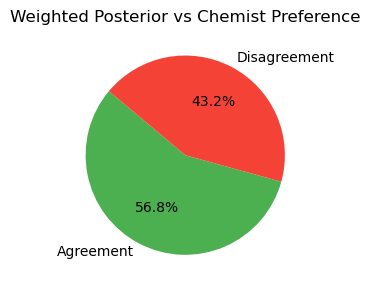

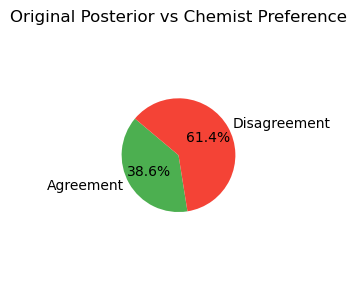

In [15]:
import matplotlib.pyplot as plt

# --- Function to plot agreement pie chart ---
def plot_agreement_pie(column_name, title):
    counts = result_df[column_name].value_counts(dropna=True)
    labels = ['Agreement', 'Disagreement']
    sizes = [counts.get(True, 0), counts.get(False, 0)]
    colors = ['#4CAF50', '#F44336']

    plt.figure(figsize=(3, 3))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# --- Plot for Weighted Posterior Match ---
plot_agreement_pie("Weighted Pref = Chemist Pref?", "Weighted Posterior vs Chemist Preference")

# --- Plot for Original Posterior Match ---
plot_agreement_pie("Original AIF = Chemist Pref?",  "Original Posterior vs Chemist Preference")

In [5]:
# Create a copy to avoid modifying original
df_change_analysis = result_df.copy()

# Label agreement transitions
def classify_change(row):
    changed = row["Changed Top Interpretation?"]
    orig_agree = row["Original AIF = Chemist Pref?"]
    new_agree = row["Weighted Pref = Chemist Pref?"]

    if not changed:
        return "Unchanged"
    elif not orig_agree and new_agree:
        return "🟢 Gained Agreement"
    elif orig_agree and not new_agree:
        return "🔴 Lost Agreement"
    elif orig_agree and new_agree:
        return "🟡 Still Agreed"
    else:
        return "⚪ Still Disagreed"

df_change_analysis["Agreement Change"] = df_change_analysis.apply(classify_change, axis=1)

# Count and percentage
summary_counts = df_change_analysis["Agreement Change"].value_counts()
summary_percent = (summary_counts / len(df_change_analysis) * 100).round(1)

# Combine into a summary DataFrame
summary_df = pd.DataFrame({
    "Count": summary_counts,
    "Percentage": summary_percent.astype(str) + "%"
})

print("📊 Agreement Change Summary:\n")
print(summary_df)

# Filter for detailed view
affected_df = df_change_analysis[df_change_analysis["Agreement Change"].isin(["🟢 Gained Agreement", "🔴 Lost Agreement"])]
print("\n🧾 Affected TRI Samples (Gained or Lost Agreement):")
affected_df[["TRI", "Chemist Preference", "Original Best AIF", "Weighted Top Interpretation", "Agreement Change"]]

📊 Agreement Change Summary:

                    Count Percentage
Agreement Change                    
Unchanged              14      31.8%
🟢 Gained Agreement     11      25.0%
🔴 Lost Agreement        8      18.2%
🟡 Still Agreed          6      13.6%
⚪ Still Disagreed       5      11.4%

🧾 Affected TRI Samples (Gained or Lost Agreement):


,TRI,Chemist Preference,Original Best AIF,Weighted Top Interpretation,Agreement Change
0,TRI_27,B,I_2,I_1,🟢 Gained Agreement
2,TRI_31,A,I_4,I_1,🔴 Lost Agreement
3,TRI_32,B,I_3,I_1,🔴 Lost Agreement
9,TRI_78,B,I_2,I_1,🟢 Gained Agreement
10,TRI_79,A,I_4,I_1,🟢 Gained Agreement
11,TRI_80,A,I_3,I_1,🟢 Gained Agreement
12,TRI_81,A,I_2,I_1,🔴 Lost Agreement
19,TRI_92,A,I_3,I_1,🟢 Gained Agreement
21,TRI_99,A,I_11,I_1,🔴 Lost Agreement
22,TRI_100,A,I_3,I_1,🟢 Gained Agreement


In [6]:
# --- Extra: Print TRI names for gained/lost agreement ---
gained = affected_df[affected_df["Agreement Change"] == "🟢 Gained Agreement"]
lost = affected_df[affected_df["Agreement Change"] == "🔴 Lost Agreement"]

print("\n✅ TRI samples that GAINED agreement:")
print(gained["TRI"].tolist())

print("\n❌ TRI samples that LOST agreement:")
print(lost["TRI"].tolist())


✅ TRI samples that GAINED agreement:
['TRI_27', 'TRI_78', 'TRI_79', 'TRI_80', 'TRI_92', 'TRI_100', 'TRI_101', 'TRI_102', 'TRI_105', 'TRI_130', 'TRI_194']

❌ TRI samples that LOST agreement:
['TRI_31', 'TRI_32', 'TRI_81', 'TRI_99', 'TRI_106', 'TRI_172', 'TRI_184', 'TRI_186']


In [7]:
# --- Total number of evaluated samples ---
total_samples = len(result_df)

# --- Count agreements ---
original_agree_count = result_df["Original AIF = Chemist Pref?"].sum()
weighted_agree_count = result_df["Weighted Pref = Chemist Pref?"].sum()

# --- Compute percentages ---
original_pct = (original_agree_count / total_samples) * 100
weighted_pct = (weighted_agree_count / total_samples) * 100

# --- Print summary ---
print(f"✅ Agreed with Chemist (Original Posterior): {original_agree_count} / {total_samples} = {original_pct:.1f}%")
print(f"✅ Agreed with Chemist (Weighted Posterior): {weighted_agree_count} / {total_samples} = {weighted_pct:.1f}%")
print(f"📊 Total Evaluated Samples: {total_samples}")

✅ Agreed with Chemist (Original Posterior): 22 / 44 = 50.0%
✅ Agreed with Chemist (Weighted Posterior): 25 / 44 = 56.8%
📊 Total Evaluated Samples: 44


In [20]:
# Check the impact of different combinations of weights, on the chemist agreement 
import json
import pandas as pd
from itertools import product

# --- Load interpretation files ---
# with open("../src/interpretations_new.json", "r") as f:
#     interpretations_default = json.load(f)
# with open("../src/interpretations_new_with_weighted_posteriors.json", "r") as f:
#     interpretations_new = json.load(f)
# with open("../src/interpretations_llm_flat_with_weighted_posteriors.json", "r") as f:
#     interpretations_llm = json.load(f)


with open("../src/interpretations_new_llm_approach_May7_flat_with_weighted.json", "r") as f:
    interpretations_default = json.load(f)
    # interpretations_new = json.load(f)
    # interpretations_llm = json.load(f)

# --- Load evaluation and mapping ---
evaluation_df = pd.read_csv("../data/alab_synthesis_data/Dara-AIF_evaluation.csv")
mapping_df = pd.read_csv("../data/alab_synthesis_data/AIFvsDara_LOG_updated.csv")
evaluation_df = evaluation_df[~evaluation_df["Run Name in ALAB"].str.contains("15")]
evaluation_df = evaluation_df.dropna(subset=["Prefered Interpretation"])

# --- Sample-specific routing ---
use_new_samples =[]# ["TRI_130", "TRI_197"]
use_llm_samples = []#["TRI_182"]

def normalize_key(name):
    return name.strip().replace("-", "_")

def get_sample(tri_key):
    if tri_key in use_new_samples:
        return interpretations_new.get(tri_key, {})
    elif tri_key in use_llm_samples:
        return interpretations_llm.get(tri_key, {})
    else:
        return interpretations_default.get(tri_key, {})

def matches_chemist_pref(selected_ix, chemist_ix):
    if pd.isna(chemist_ix) or pd.isna(selected_ix):
        return False
    if "&" in str(chemist_ix):
        return selected_ix in chemist_ix.split(" & ")
    return selected_ix == chemist_ix

# --- Grid search setup ---
weight_range = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
grid_results = []

for w_llm, w_bs, w_rwp, w_score in product(weight_range, repeat=4):
    if w_llm + w_bs == 0 or w_rwp + w_score == 0:
        continue  # avoid division by zero

    agreements = 0
    total = 0

    for _, row in evaluation_df.iterrows():
        run_name = row["Run Name in ALAB"]
        tri_key = normalize_key(run_name)
        chemist_pref = row["Prefered Interpretation"]

        mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
        if mapping_row.empty:
            continue

        explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
        a_label, b_label = ("AIF", "DARA") if explanation_a == "AIF interpretation" else ("DARA", "AIF")

        sample = get_sample(tri_key)
        if not sample or "I_1" not in sample:
            continue

        aif_candidates = {k: v for k, v in sample.items() if k != "I_1"}
        if not aif_candidates:
            continue

        if chemist_pref == "A":
            chem_pref_ix = "I_1" if a_label == "DARA" else max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))
        elif chemist_pref == "B":
            chem_pref_ix = max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1)) if b_label == "AIF" else "I_1"
        elif chemist_pref == "both A & B":
            chem_pref_ix = "I_1 & " + max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))
        else:
            chem_pref_ix = "neither"

        # Compute weighted posteriors
        weighted_posteriors = {}
        for name, data in sample.items():
            llm = data.get("LLM_interpretation_likelihood", 0)
            bs = data.get("balance_score", 0)
            rwp = data.get("normalized_rwp", 0)
            score = data.get("normalized_score", 0)
            weighted_prior = (w_llm * llm + w_bs * bs) / (w_llm + w_bs)
            weighted_fit = (w_rwp * rwp + w_score * score) / (w_rwp + w_score)
            weighted_posteriors[name] = weighted_prior * weighted_fit

        total_weighted = sum(weighted_posteriors.values())
        if total_weighted > 0:
            for k in weighted_posteriors:
                weighted_posteriors[k] /= total_weighted

        top_weighted = max(weighted_posteriors.items(), key=lambda x: x[1])[0]

        if matches_chemist_pref(top_weighted, chem_pref_ix):
            agreements += 1
        total += 1

    agreement_ratio = agreements / total * 100 if total > 0 else 0
    grid_results.append({
        "w_llm": w_llm,
        "w_bs": w_bs,
        "w_rwp": w_rwp,
        "w_score": w_score,
        "Agreement %": round(agreement_ratio, 2)
    })

# --- Output results ---
grid_df = pd.DataFrame(grid_results)
grid_df_sorted = grid_df.sort_values(by="Agreement %", ascending=False)
pd.set_option("display.max_rows", None)
grid_df_sorted.head(20)

# Optional: Save
# grid_df_sorted.to_csv("grid_agreement_results.csv", index=False)

,w_llm,w_bs,w_rwp,w_score,Agreement %
311,0.2,0.6,1.0,0.4,68.89
536,0.4,0.8,0.4,0.0,66.67
588,0.4,1.0,0.8,1.0,66.67
267,0.2,0.4,0.6,1.0,66.67
264,0.2,0.4,0.6,0.4,66.67
262,0.2,0.4,0.6,0.0,66.67
261,0.2,0.4,0.4,1.0,66.67
594,0.4,1.0,1.0,1.0,66.67
260,0.2,0.4,0.4,0.8,66.67
591,0.4,1.0,1.0,0.4,66.67


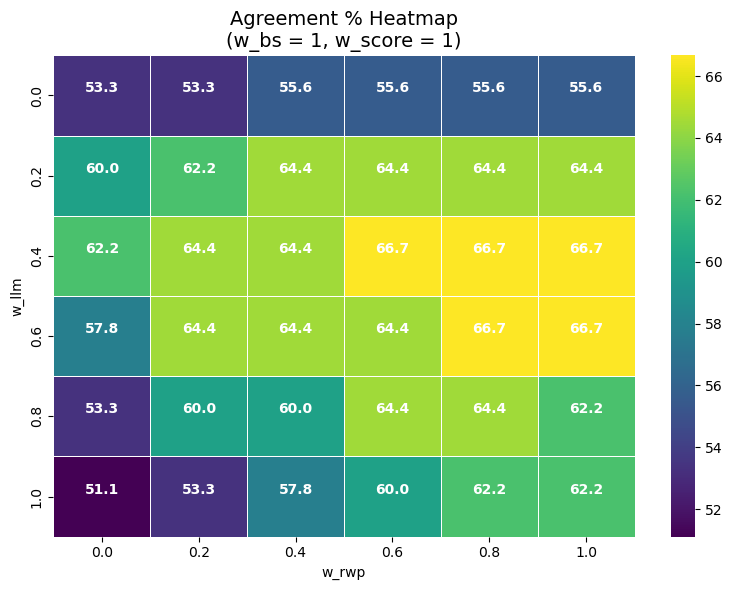

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Filter for w_bs = 1 and w_score = 1 ---
filtered_df = grid_df_sorted[
    (grid_df_sorted["w_bs"] == 1.0) & (grid_df_sorted["w_score"] == 1.0)
]

# Pivot for heatmap
heatmap_data = filtered_df.pivot_table(
    index="w_llm",
    columns="w_rwp",
    values="Agreement %",
    aggfunc="mean"
).sort_index(ascending=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=False,  # We will add our own annotations
    fmt=".1f",
    cmap="viridis",
    linewidths=0.5,
    linecolor='white'
)

# Add annotations manually above each cell
for y in range(heatmap_data.shape[0]):
    for x in range(heatmap_data.shape[1]):
        value = heatmap_data.iloc[y, x]
        if pd.notna(value):
            ax.text(
                x + 0.5, y + 0.5,  # adjust vertical offset
                f"{value:.1f}",
                ha='center', va='bottom',
                fontsize=10,
                color='white',
                weight='bold'
            )

plt.title("Agreement % Heatmap\n(w_bs = 1, w_score = 1)", fontsize=14)
plt.xlabel("w_rwp")
plt.ylabel("w_llm")
plt.tight_layout()
plt.show()

In [1]:
from skopt import gp_minimize

def evaluate_agreement(w_llm, w_bs, w_rwp, w_score):
    agree, total = 0, 0

    for _, row in evaluation_df.iterrows():
        run_name = row["Run Name in ALAB"]
        tri_key = normalize_key(run_name)
        chemist_pref = row["Prefered Interpretation"]

        mapping_row = mapping_df[mapping_df["Run Name in ALAB"] == run_name]
        if mapping_row.empty:
            continue

        explanation_a = mapping_row.iloc[0]["Interpr A - explanation"]
        a_label, b_label = ("AIF", "DARA") if explanation_a == "AIF interpretation" else ("DARA", "AIF")

        sample = interpretations_default.get(tri_key, {})
        if not sample or "I_1" not in sample:
            continue

        aif_candidates = {k: v for k, v in sample.items() if k != "I_1"}
        if not aif_candidates:
            continue

        # ORIGINAL AIF and DARA assignments
        original_aif = max(aif_candidates, key=lambda k: sample[k].get("posterior_probability", -1))
        dara = "I_1"

        # Compute weighted posteriors
        weighted_posteriors = {}
        for name, data in sample.items():
            llm = data.get("LLM_interpretation_likelihood", 0)
            bs = data.get("balance_score", 0)
            rwp = data.get("normalized_rwp", 0)
            score = data.get("normalized_score", 0)
            prior = (w_llm * llm + w_bs * bs) / (w_llm + w_bs) if (w_llm + w_bs) else 0
            fit = (w_rwp * rwp + w_score * score) / (w_rwp + w_score) if (w_rwp + w_score) else 0
            weighted_posteriors[name] = prior * fit

        # Normalize
        total_weight = sum(weighted_posteriors.values()) or 1e-8
        for k in weighted_posteriors:
            weighted_posteriors[k] /= total_weight

        # New AIF = top weighted interpretation
        new_aif = max(weighted_posteriors.items(), key=lambda x: x[1])[0]

        # Check agreement based on chemist logic
        if chemist_pref == "A":
            agrees = new_aif == dara
        elif chemist_pref == "B":
            agrees = new_aif == original_aif
        elif chemist_pref == "both A & B":
            agrees = new_aif in [dara, original_aif]
        elif chemist_pref == "neither":
            agrees = new_aif not in [dara, original_aif]
        else:
            agrees = False

        agree += int(agrees)
        total += 1

    return round((agree / total) * 100, 2) if total > 0 else 0
def objective(weights):
    w_llm, w_bs, w_rwp, w_score = weights
    if w_llm + w_bs == 0 or w_rwp + w_score == 0:
        return 1.0  # Worst possible loss

    agreement = evaluate_agreement(w_llm, w_bs, w_rwp, w_score)
    return -agreement  # We want to maximize agreement

res = gp_minimize(
    objective,
    dimensions=[(0.0, 1.0)] * 4,
    n_calls=50,
    random_state=42
)

best_weights = res.x  # The optimal combination

NameError: name 'evaluation_df' is not defined